In [1]:
# Model Building and Evaluation for Loan Default Prediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report,
                            precision_recall_curve, roc_curve, average_precision_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
import dill
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the preprocessed data
print("Loading preprocessed data...")
X_train = np.load('../data/X_train_processed.npy')
X_test = np.load('../data/X_test_processed.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

Loading preprocessed data...


In [3]:
# Load feature names for interpretation later
with open('../data/selected_features.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"Loaded training data: {X_train.shape}")
print(f"Loaded testing data: {X_test.shape}")


Loaded training data: (12762, 20)
Loaded testing data: (1898, 20)


In [5]:
# define evaluation functions

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fully Paid', 'Default'],
                yticklabels=['Fully Paid', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'./figures/model_metrics/confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'./figures/model_metrics/roc_curve_{model_name.replace(" ", "_").lower()}.png')
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_curve, precision_curve, 
             label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.savefig(f'./figures/model_metrics/pr_curve_{model_name.replace(" ", "_").lower()}.png')
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_pred_proba': y_pred_proba
    }

In [6]:
def cross_validate_model(model, X, y, model_name, cv=5):
    """Perform cross-validation and return mean scores"""
    # Cross-validate with multiple metrics
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    
    print(f"\n--- {model_name} Cross-Validation (CV={cv}) ---")
    print(f"CV Accuracy: {accuracy:.4f}")
    print(f"CV Precision: {precision:.4f}")
    print(f"CV Recall: {recall:.4f}")
    print(f"CV F1 Score: {f1:.4f}")
    print(f"CV ROC-AUC: {roc_auc:.4f}")
    
    return {
        'name': model_name,
        'cv_accuracy': accuracy,
        'cv_precision': precision,
        'cv_recall': recall,
        'cv_f1': f1,
        'cv_roc_auc': roc_auc
    }

In [7]:
print("\n" + "="*50)
print("Building and evaluating baseline models...")
print("="*50)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


Building and evaluating baseline models...



Training Logistic Regression...

--- Logistic Regression Performance ---
Accuracy: 0.6185
Precision: 0.2309
Recall: 0.5993
F1 Score: 0.3333
ROC-AUC: 0.6650
Average Precision: 0.2876

--- Logistic Regression Cross-Validation (CV=5) ---
CV Accuracy: 0.6142
CV Precision: 0.6192
CV Recall: 0.5932
CV F1 Score: 0.6059
CV ROC-AUC: 0.6624

Training Decision Tree...

--- Decision Tree Performance ---
Accuracy: 0.7165
Precision: 0.1878
Recall: 0.2351
F1 Score: 0.2088
ROC-AUC: 0.5214
Average Precision: 0.1659

--- Decision Tree Cross-Validation (CV=5) ---
CV Accuracy: 0.7992
CV Precision: 0.7865
CV Recall: 0.8155
CV F1 Score: 0.7888
CV ROC-AUC: 0.7992

Training Random Forest...

--- Random Forest Performance ---
Accuracy: 0.7903
Precision: 0.2736
Recall: 0.1921
F1 Score: 0.2257
ROC-AUC: 0.6448
Average Precision: 0.2498

--- Random Forest Cross-Validation (CV=5) ---
CV Accuracy: 0.8808
CV Precision: 0.8838
CV Recall: 0.8752
CV F1 Score: 0.8735
CV ROC-AUC: 0.9509

Training Gradient Boosting...

--

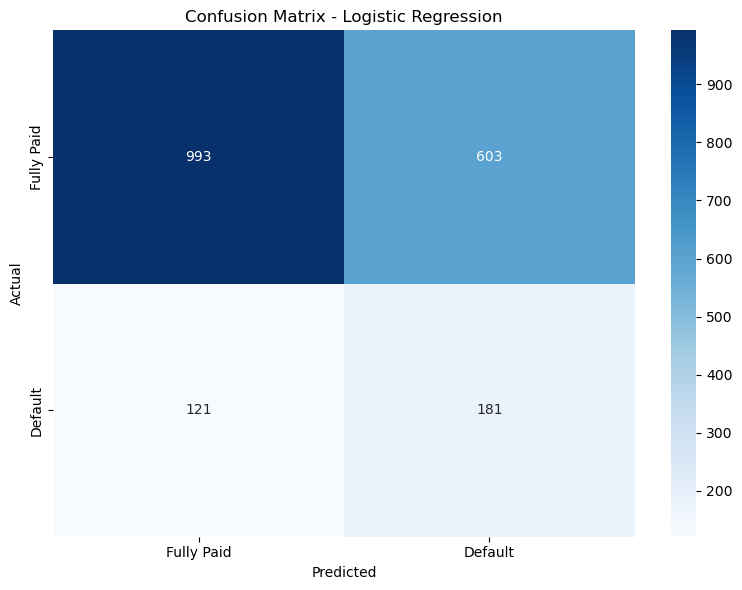

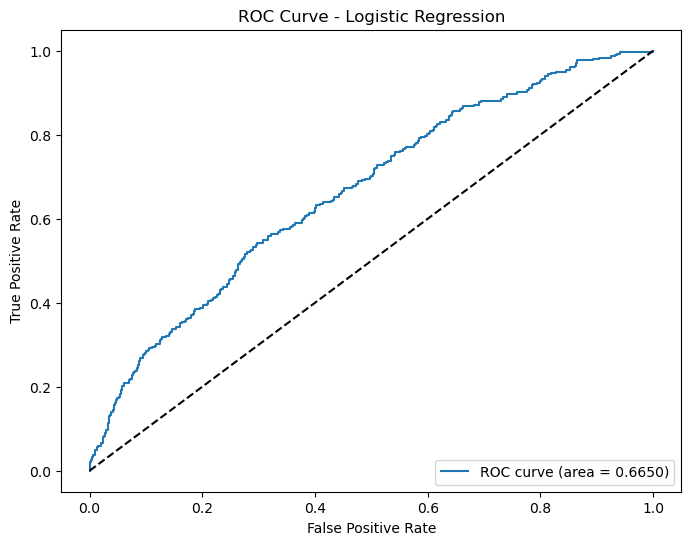

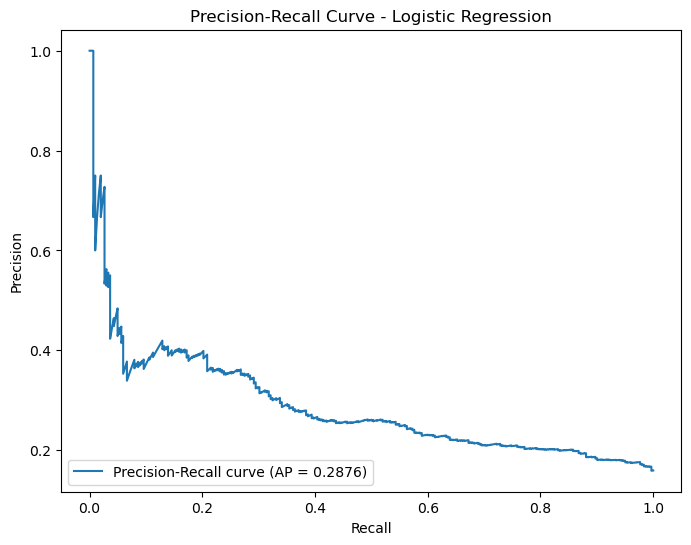

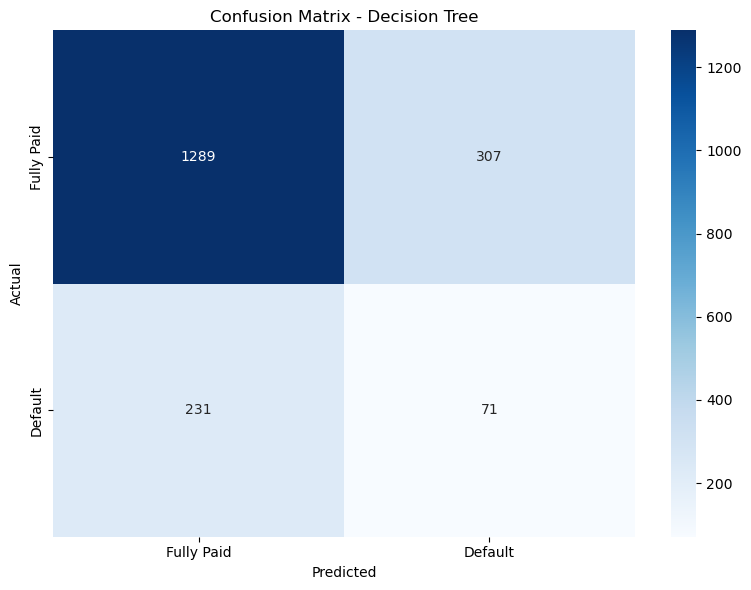

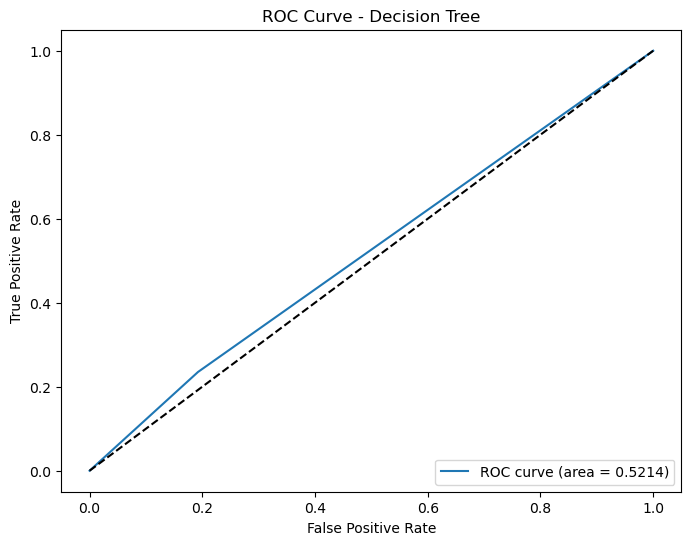

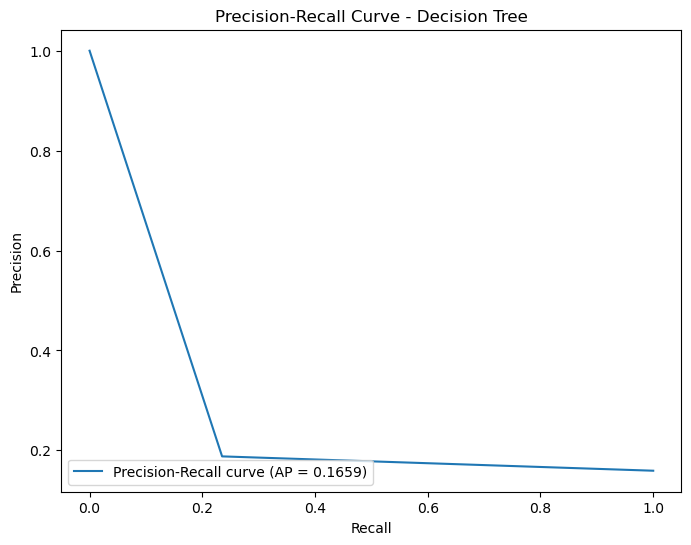

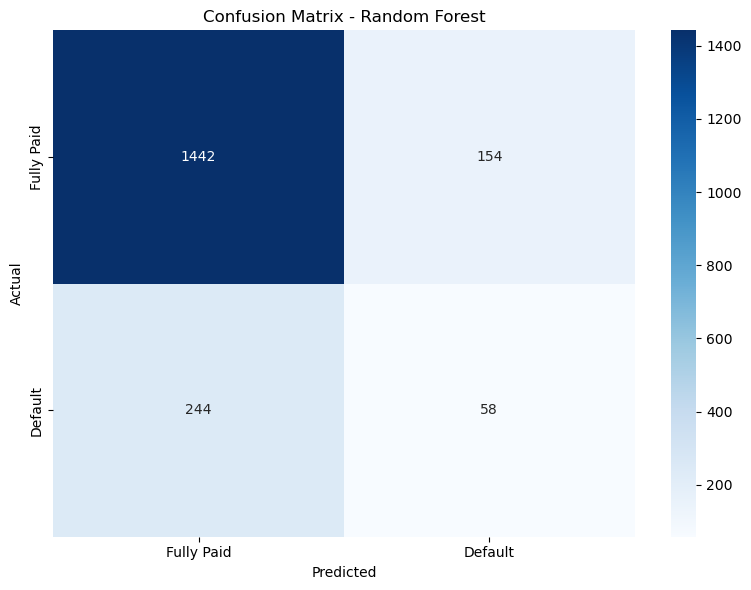

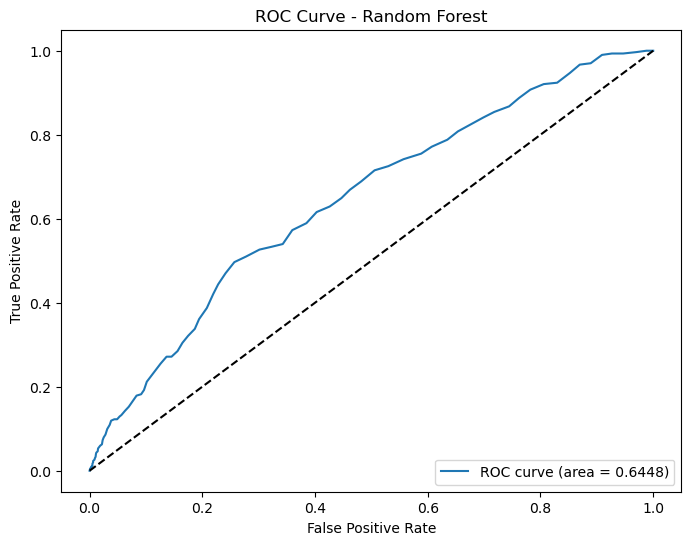

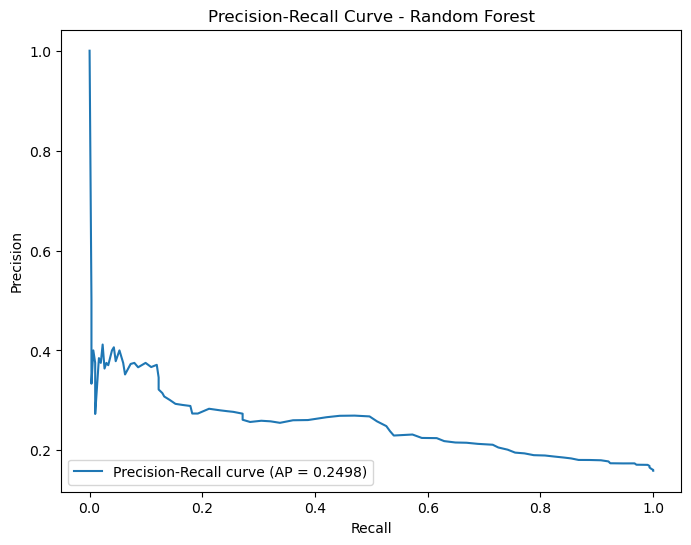

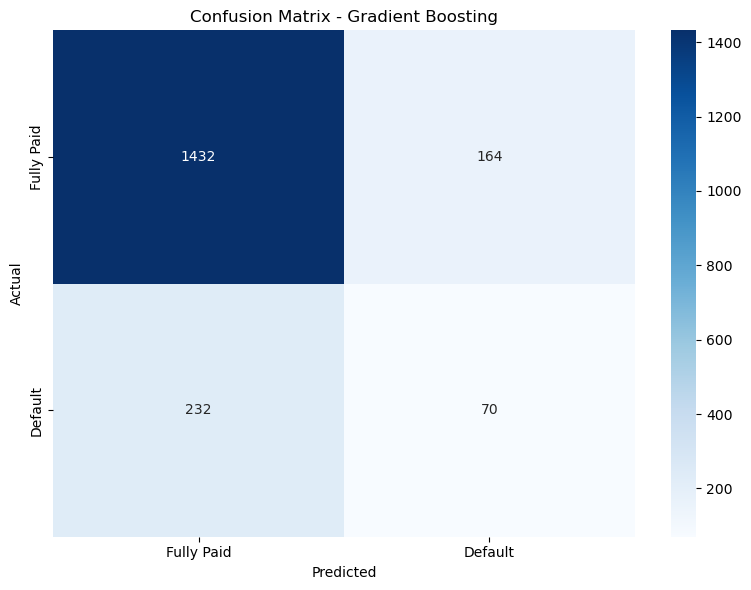

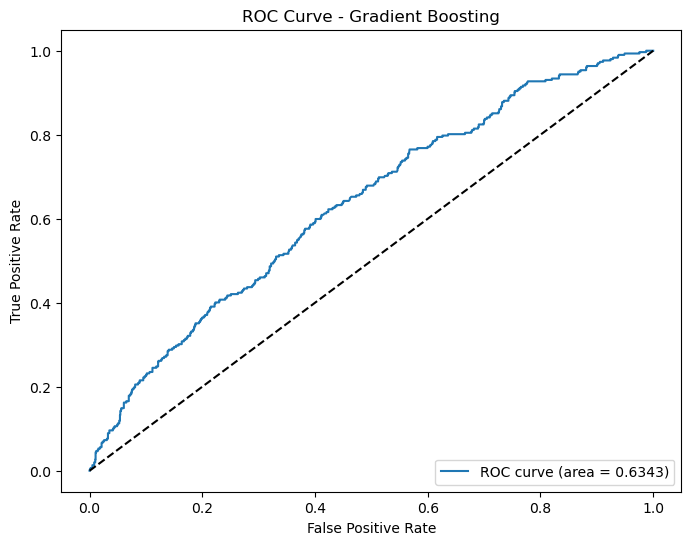

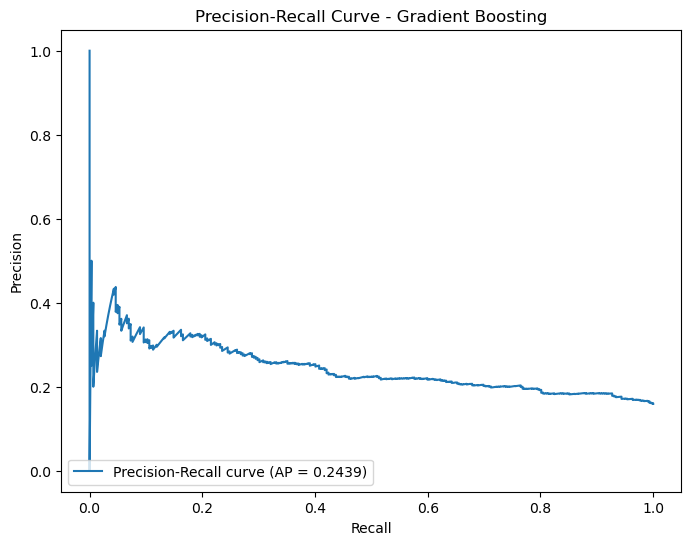

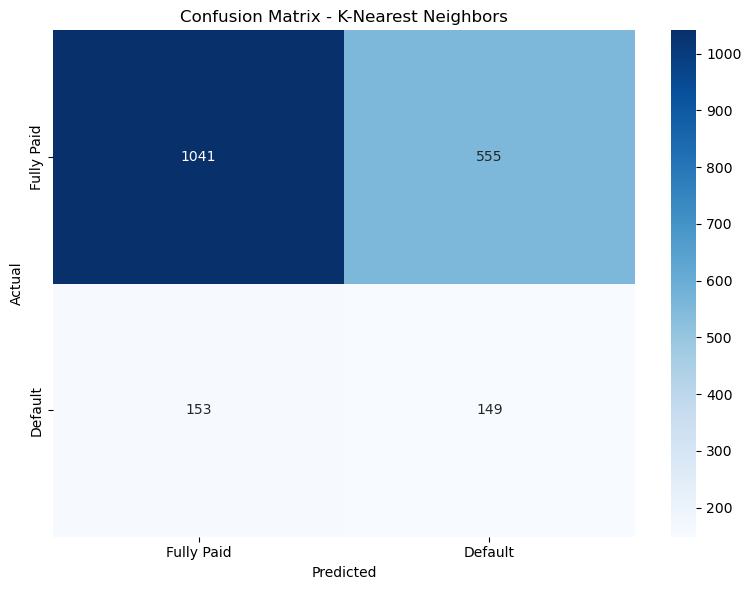

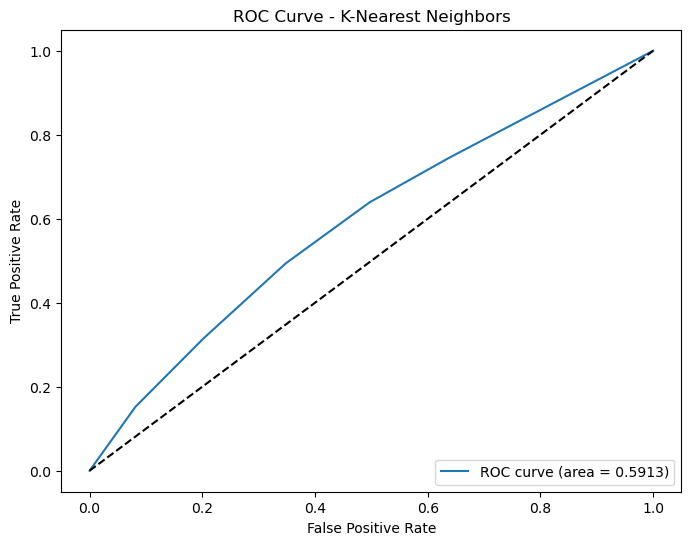

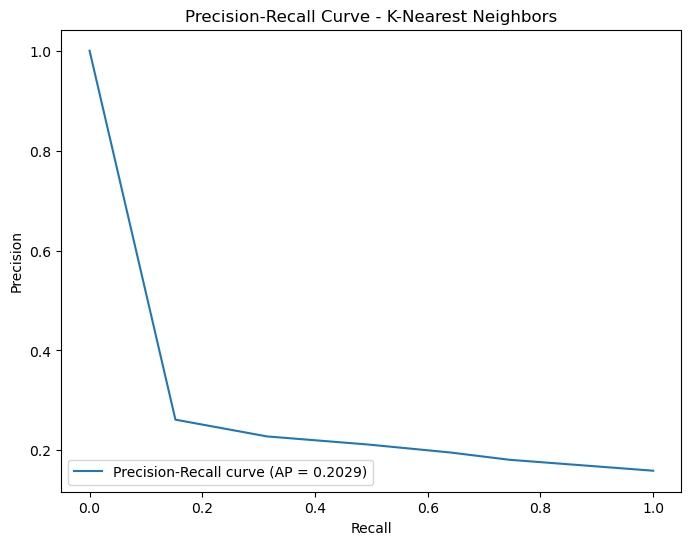

In [8]:
# Train and evaluate each model
results = []
cv_results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)
    
    # Cross-validation
    cv_result = cross_validate_model(model, X_train, y_train, name)
    cv_results.append(cv_result)

# Compare model performances
models_comparison = pd.DataFrame([
    {
        'Model': r['name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1 Score': r['f1'],
        'ROC-AUC': r['roc_auc'],
        'Avg Precision': r['avg_precision']
    } for r in results
])

print("\nModel Performance Comparison:")
print(models_comparison)

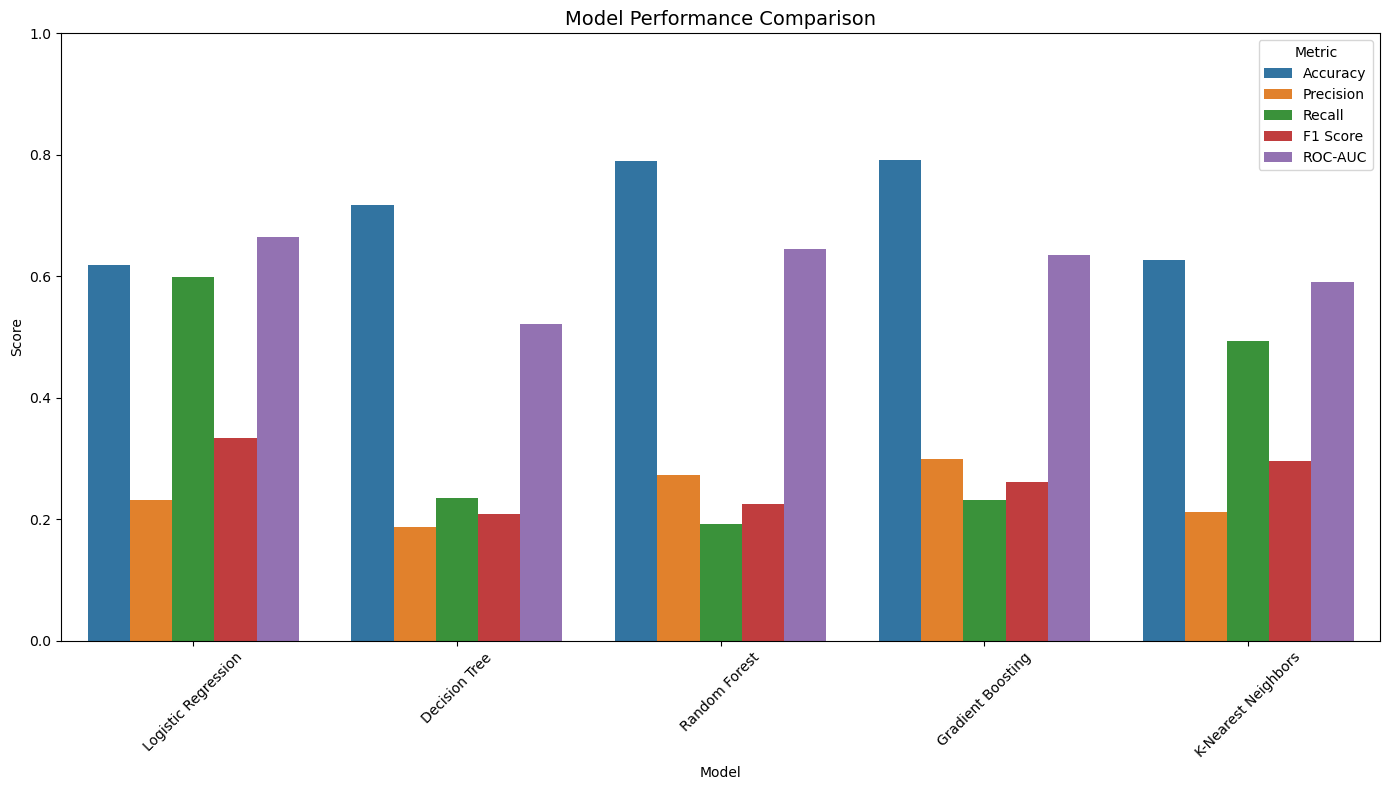


Best performing model: Logistic Regression with ROC-AUC: 0.6650


In [9]:
# Visualize performance comparison
plt.figure(figsize=(14, 8))
models_comparison_melted = pd.melt(models_comparison, 
                                   id_vars=['Model'], 
                                   value_vars=['Accuracy', 'Precision', 'Recall', 
                                              'F1 Score', 'ROC-AUC'])
sns.barplot(x='Model', y='value', hue='variable', data=models_comparison_melted)
plt.title('Model Performance Comparison', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('./figures/model_metrics/model_comparison.png')
plt.show()

# Find the best performing model based on ROC-AUC
best_model_idx = models_comparison['ROC-AUC'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
best_roc_auc = models_comparison.loc[best_model_idx, 'ROC-AUC']
print(f"\nBest performing model: {best_model_name} with ROC-AUC: {best_roc_auc:.4f}")


In [10]:
print("\n" + "="*50)
print(f"Hyperparameter tuning for {best_model_name}...")
print("="*50)

# Define parameter grids for each model type
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan, 2: Euclidean
    }
}


Hyperparameter tuning for Logistic Regression...


In [11]:
# Get the best model and its parameter grid
best_model = next(model for name, model in models.items() if name == best_model_name)
best_param_grid = param_grids[best_model_name]

# Perform grid search
print(f"Performing grid search for {best_model_name}...")
grid_search = GridSearchCV(
    best_model, 
    best_param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best parameters and performance
print("\nBest hyperparameters:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Performing grid search for Logistic Regression...

Best hyperparameters:
{'C': 0.01, 'class_weight': None, 'solver': 'liblinear'}
Best cross-validation score: 0.6625



--- Tuned Logistic Regression Performance ---
Accuracy: 0.6164
Precision: 0.2297
Recall: 0.5993
F1 Score: 0.3321
ROC-AUC: 0.6646
Average Precision: 0.2887

Improvement over baseline:
ROC-AUC improvement: -0.0004 (-0.06%)


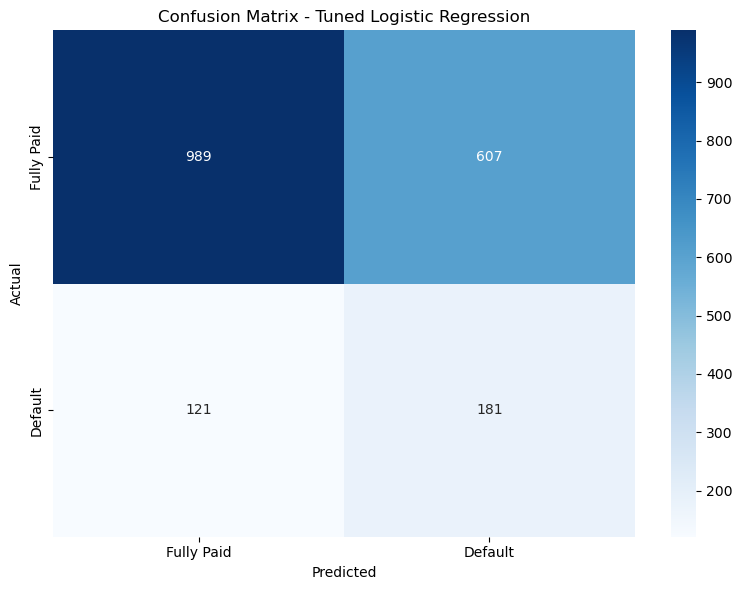

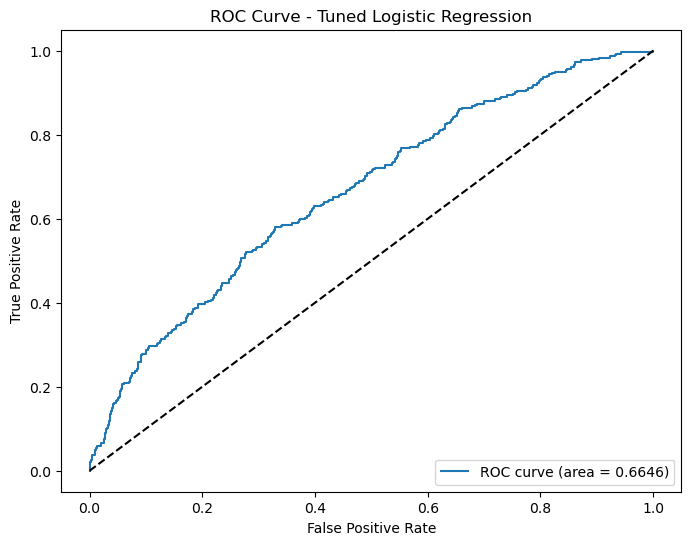

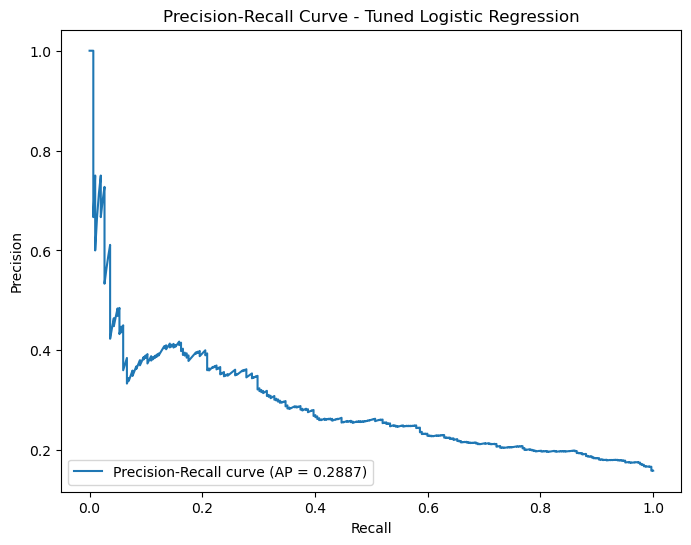

In [12]:
# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
tuned_result = evaluate_model(tuned_model, X_train, X_test, y_train, y_test, f"Tuned {best_model_name}")

# Compare with the baseline model
print("\nImprovement over baseline:")
baseline_roc_auc = next(r['roc_auc'] for r in results if r['name'] == best_model_name)
improvement = tuned_result['roc_auc'] - baseline_roc_auc
print(f"ROC-AUC improvement: {improvement:.4f} ({improvement/baseline_roc_auc*100:.2f}%)")

In [13]:
print("\n" + "="*50)
print("Feature importance analysis for Logistic Regression...")
print("="*50)

# Get coefficients from Logistic Regression model
coefficients = tuned_model.coef_[0]

# Create a dataframe of feature names and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(coefficients)],  # Ensure we don't go out of bounds
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value for importance
feature_importance = feature_importance.sort_values('Absolute_Coefficient', ascending=False)

print("\nTop 15 most important features:")
print(feature_importance.head(15))



Feature importance analysis for Logistic Regression...

Top 15 most important features:
                    Feature  Coefficient  Absolute_Coefficient
7            inq.last.6mths     0.272964              0.272964
8                  int.rate     0.204027              0.204027
1   payment_to_income_ratio     0.193644              0.193644
3       meets_credit_policy    -0.145661              0.145661
13             int_tier_Low    -0.127183              0.127183
2        inquiries_per_year    -0.105074              0.105074
12       fico_cat_Excellent    -0.102091              0.102091
5         has_public_record     0.086647              0.086647
6                 revol.bal     0.072574              0.072574
10            fico_cat_Fair     0.056715              0.056715
9             fico_cat_Poor     0.045040              0.045040
0               installment    -0.041527              0.041527
16       int_tier_Very High     0.030408              0.030408
15            int_tier_High  

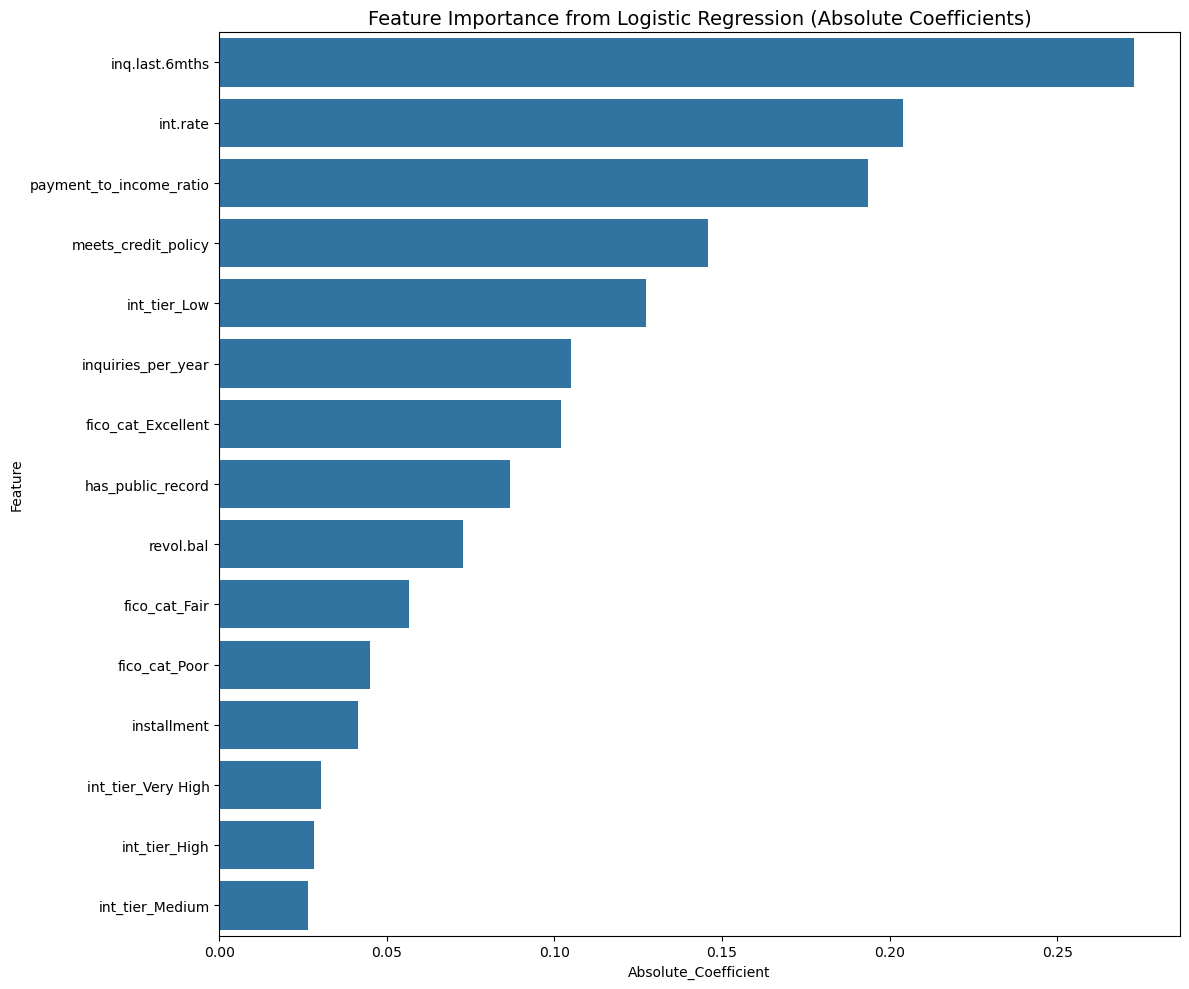

In [14]:
# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Absolute_Coefficient', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance from Logistic Regression (Absolute Coefficients)', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/model_metrics/logistic_regression_feature_importance.png')
plt.show()

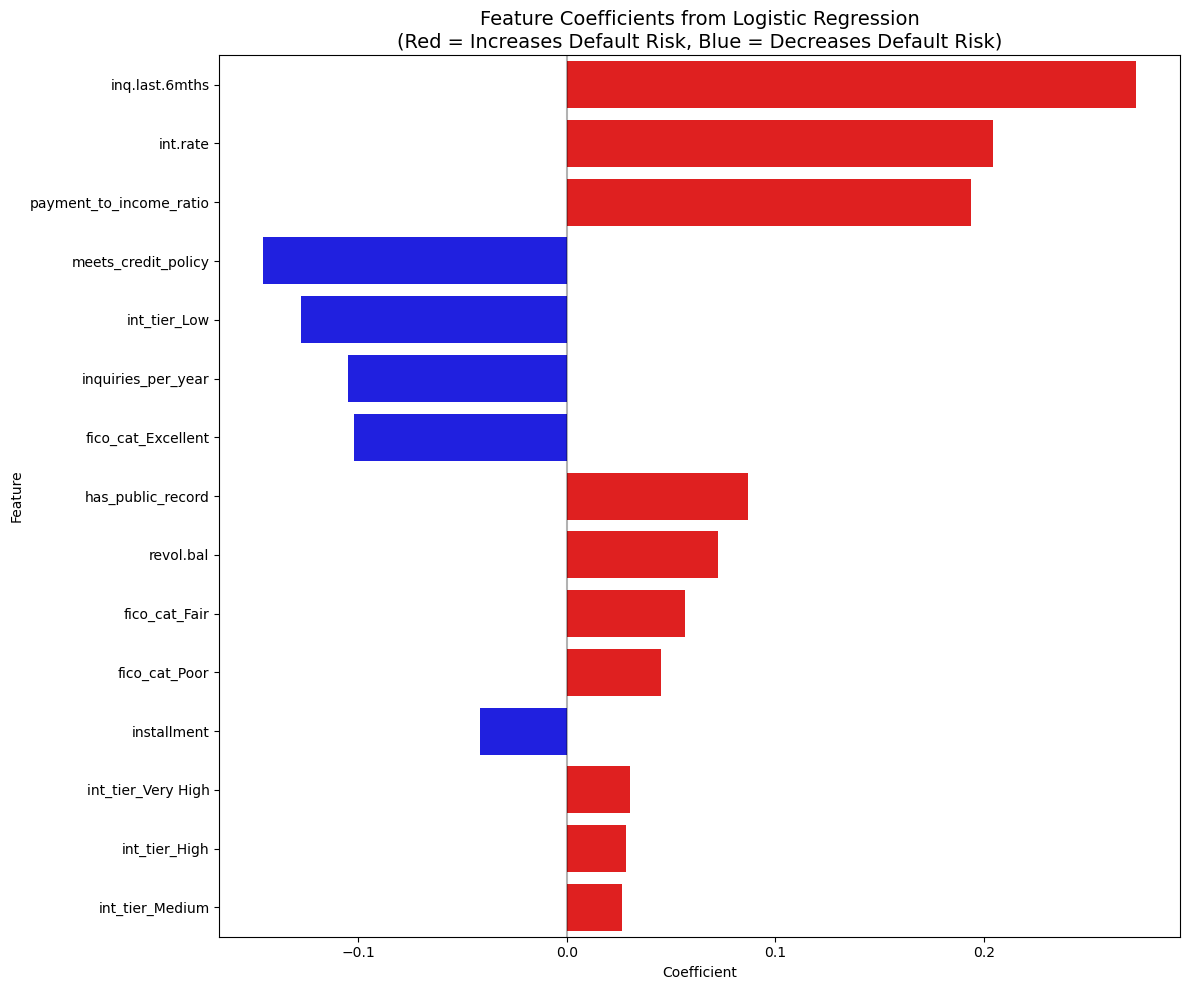

In [15]:
# Also plot coefficients with sign to show direction of effect
plt.figure(figsize=(12, 10))
# Create a colormap: blue for negative, red for positive
colors = ['blue' if c < 0 else 'red' for c in feature_importance.head(15)['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15), palette=colors)
plt.title('Feature Coefficients from Logistic Regression\n(Red = Increases Default Risk, Blue = Decreases Default Risk)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/logistic_regression_coefficients.png')
plt.show()

In [17]:
from sklearn.metrics import (roc_curve, precision_recall_curve, auc, 
                            confusion_matrix, classification_report)

In [ ]:
print("\n" + "="*50)
print("Optimizing decision threshold...")
print("="*50)

# Get predicted probabilities on test set
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Create a dataframe to analyze different thresholds
threshold_data = []


# Test different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
for threshold in thresholds_to_test:
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
    
    # Business metrics (example - these can be tailored to specific business needs)
    # Assuming a loan amount of $10,000 on average:
    # Profit from correct approval: $1,500 (15% interest)
    # Loss from default: -$5,000 (50% of loan amount)
    avg_loan_amount = 10000
    profit_correct_approval = 1500
    loss_from_default = -5000
    
    # Expected profit calculation
    profit = (tn * 0) + (fp * loss_from_default) + (fn * 0) + (tp * profit_correct_approval)
    profit_per_loan = profit / len(y_test)
    
    threshold_data.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1': f1,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Expected_Profit': profit,
        'Profit_Per_Loan': profit_per_loan
    })

threshold_df = pd.DataFrame(threshold_data)

# Print threshold analysis
print("\nThreshold analysis:")
print(threshold_df[['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1', 'Expected_Profit']])


Optimizing decision threshold...

Threshold analysis:
    Threshold  Accuracy  Precision    Recall        F1  Expected_Profit
0        0.10  0.159115   0.158755  0.996689  0.273885         -7523500
1        0.15  0.160695   0.159007  0.996689  0.274260         -7508500
2        0.20  0.206533   0.166667  0.996689  0.285579         -7073500
3        0.25  0.234457   0.170201  0.983444  0.290181         -6794500
4        0.30  0.255005   0.173325  0.976821  0.294411         -6592500
5        0.35  0.304004   0.179358  0.943709  0.301428         -6092500
6        0.40  0.380927   0.189324  0.880795  0.311658         -5296000
7        0.45  0.498946   0.206865  0.758278  0.325053         -4046500
8        0.50  0.616438   0.229695  0.599338  0.332110         -2763500
9        0.55  0.712856   0.263158  0.447020  0.331288         -1687500
10       0.60  0.767123   0.296512  0.337748  0.315789         -1057000
11       0.65  0.806112   0.353982  0.264901  0.303030          -610000
12       

In [19]:
# Find the optimal threshold based on different criteria
max_f1_threshold = threshold_df.loc[threshold_df['F1'].idxmax()]['Threshold']
max_profit_threshold = threshold_df.loc[threshold_df['Expected_Profit'].idxmax()]['Threshold']

print(f"\nOptimal threshold for maximizing F1 Score: {max_f1_threshold:.2f}")
print(f"F1 Score at this threshold: {threshold_df.loc[threshold_df['F1'].idxmax()]['F1']:.4f}")

print(f"\nOptimal threshold for maximizing Expected Profit: {max_profit_threshold:.2f}")
print(f"Expected Profit at this threshold: ${threshold_df.loc[threshold_df['Expected_Profit'].idxmax()]['Expected_Profit']:.2f}")
print(f"Profit Per Loan at this threshold: ${threshold_df.loc[threshold_df['Expected_Profit'].idxmax()]['Profit_Per_Loan']:.2f}")



Optimal threshold for maximizing F1 Score: 0.50
F1 Score at this threshold: 0.3321

Optimal threshold for maximizing Expected Profit: 0.85
Expected Profit at this threshold: $-6000.00
Profit Per Loan at this threshold: $-3.16


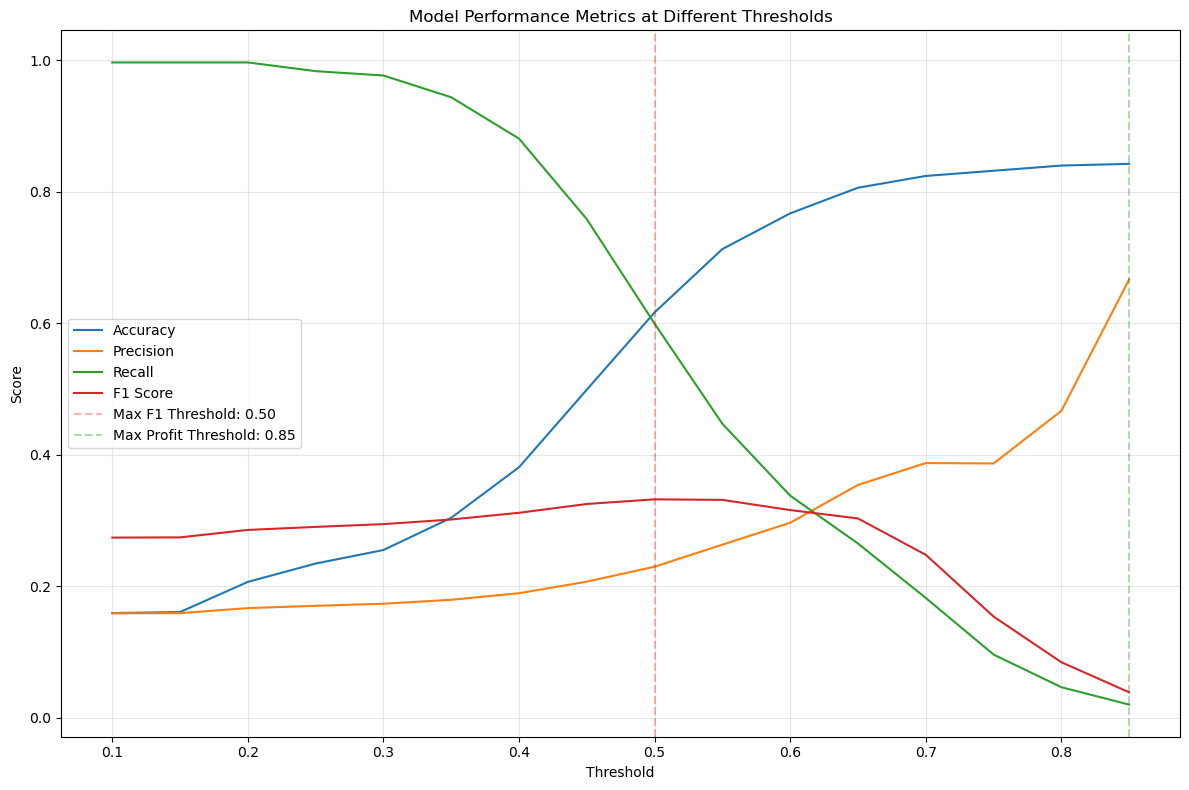

In [20]:
# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], label='Accuracy')
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall')
plt.plot(threshold_df['Threshold'], threshold_df['F1'], label='F1 Score')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.3, label=f'Max F1 Threshold: {max_f1_threshold:.2f}')
plt.axvline(x=max_profit_threshold, color='green', linestyle='--', alpha=0.3, label=f'Max Profit Threshold: {max_profit_threshold:.2f}')
plt.title('Model Performance Metrics at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/threshold_metrics.png')
plt.show()


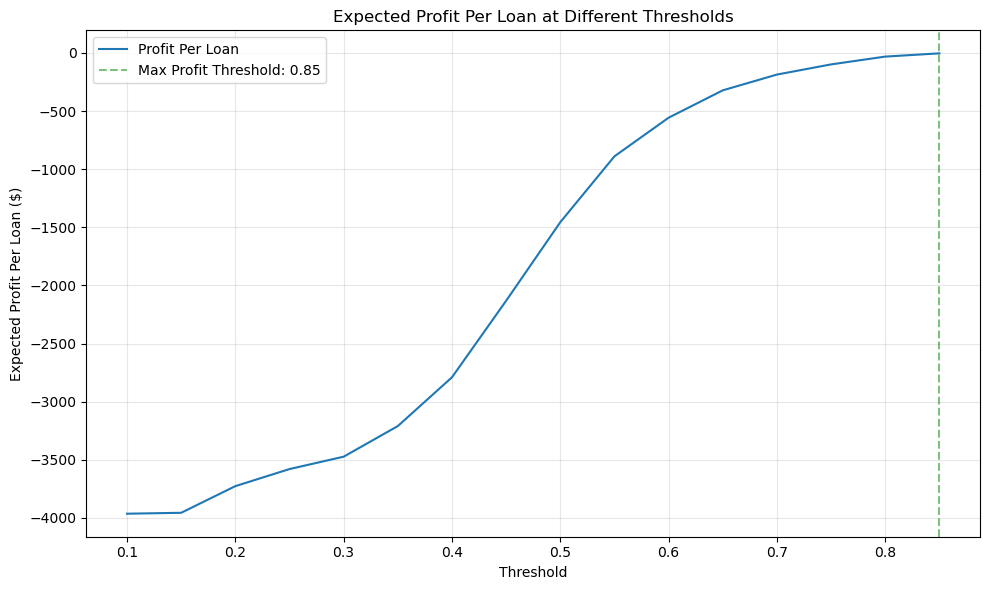

In [21]:
# Plot profit vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['Threshold'], threshold_df['Profit_Per_Loan'], label='Profit Per Loan')
plt.axvline(x=max_profit_threshold, color='green', linestyle='--', alpha=0.5, 
            label=f'Max Profit Threshold: {max_profit_threshold:.2f}')
plt.title('Expected Profit Per Loan at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Expected Profit Per Loan ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/threshold_profit.png')
plt.show()

In [22]:
print("\n" + "="*50)
print("Final model evaluation with optimal threshold...")
print("="*50)

# Choose the threshold based on business objectives
# In this case, we'll use the profit-maximizing threshold
optimal_threshold = max_profit_threshold
print(f"Using profit-maximizing threshold: {optimal_threshold:.2f}")



Final model evaluation with optimal threshold...
Using profit-maximizing threshold: 0.85


In [23]:
# Apply the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Generate confusion matrix with optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

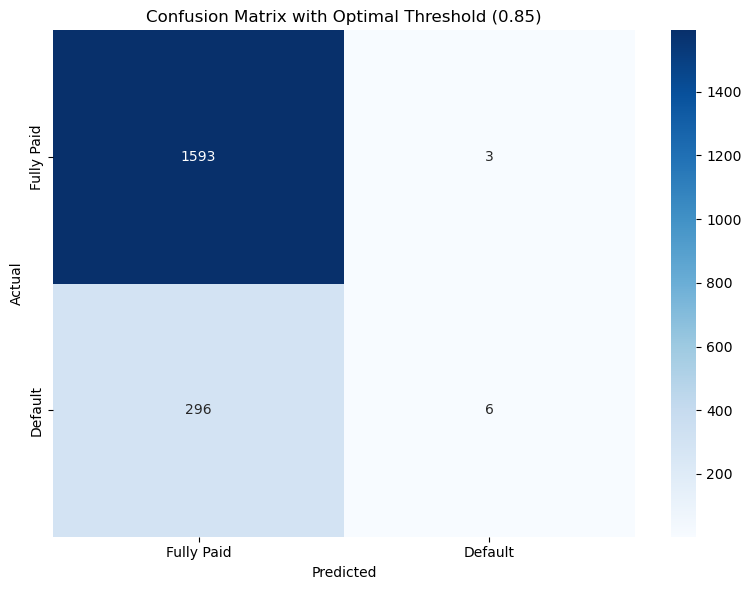

In [25]:
# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix with Optimal Threshold ({optimal_threshold:.2f})')
plt.tight_layout()
plt.savefig('./figures/model_metrics/confusion_matrix_optimal.png')
plt.show()

In [26]:
# Calculate and display classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))



Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1596
           1       0.67      0.02      0.04       302

    accuracy                           0.84      1898
   macro avg       0.75      0.51      0.48      1898
weighted avg       0.82      0.84      0.77      1898



In [27]:
# Business impact analysis
total_loans = len(y_test)
default_rate = sum(y_test) / total_loans


In [28]:
# Using our example business metrics from earlier
avg_loan_amount = 10000
profit_correct_approval = 1500
loss_from_default = -5000


In [29]:
# Calculate business metrics
total_loan_value = total_loans * avg_loan_amount
approved_loans = tp + fp
rejected_loans = tn + fn
approval_rate = approved_loans / total_loans


In [30]:
# Profit calculation
profit_from_true_positives = tp * profit_correct_approval
loss_from_false_positives = fp * loss_from_default
net_profit = profit_from_true_positives + loss_from_false_positives
profit_per_approved_loan = net_profit / approved_loans if approved_loans > 0 else 0
profit_per_total_loan = net_profit / total_loans

In [31]:
print("\nBusiness Impact Analysis:")
print(f"Total number of loans evaluated: {total_loans}")
print(f"Actual default rate: {default_rate:.2%}")
print(f"Loans approved: {approved_loans} ({approval_rate:.2%})")
print(f"Loans rejected: {rejected_loans} ({1-approval_rate:.2%})")
print(f"Correct approvals (TP): {tp}")
print(f"Incorrect approvals (FP): {fp}")
print(f"Missed opportunities (FN): {fn}")
print(f"Correct rejections (TN): {tn}")
print(f"\nTotal profit: ${net_profit:.2f}")
print(f"Profit per approved loan: ${profit_per_approved_loan:.2f}")
print(f"Profit per loan in portfolio: ${profit_per_total_loan:.2f}")


Business Impact Analysis:
Total number of loans evaluated: 1898
Actual default rate: 15.91%
Loans approved: 9 (0.47%)
Loans rejected: 1889 (99.53%)
Correct approvals (TP): 6
Incorrect approvals (FP): 3
Missed opportunities (FN): 296
Correct rejections (TN): 1593

Total profit: $-6000.00
Profit per approved loan: $-666.67
Profit per loan in portfolio: $-3.16


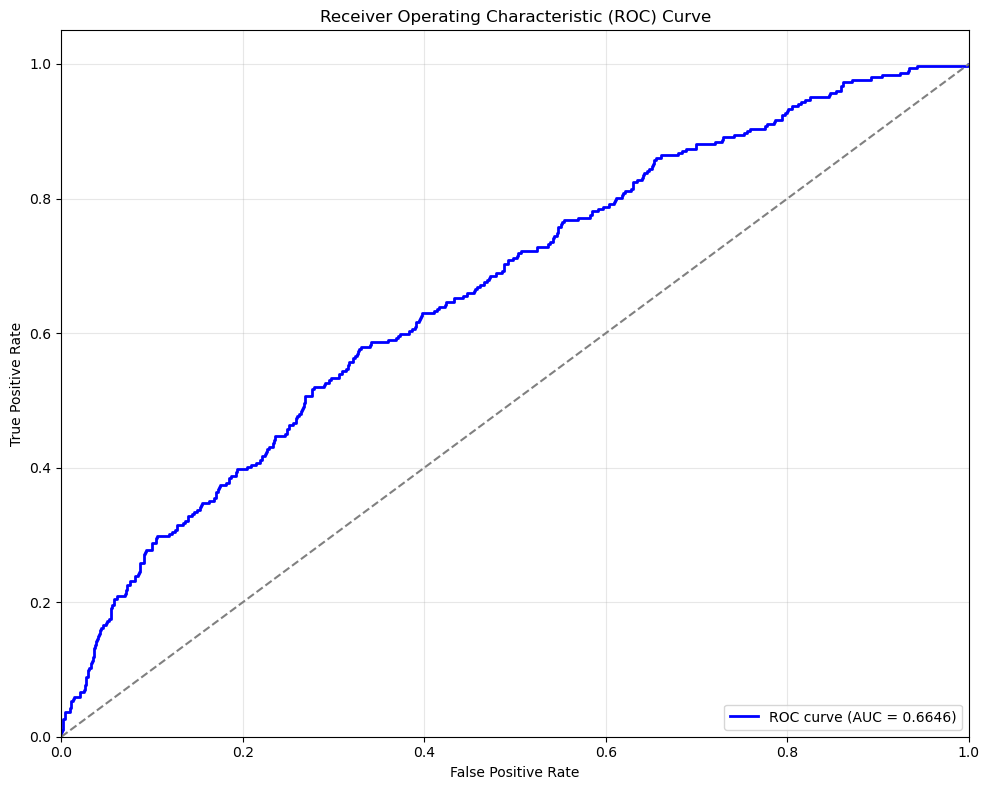

In [32]:

# Calculate and display ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/roc_curve_final.png')
plt.show()

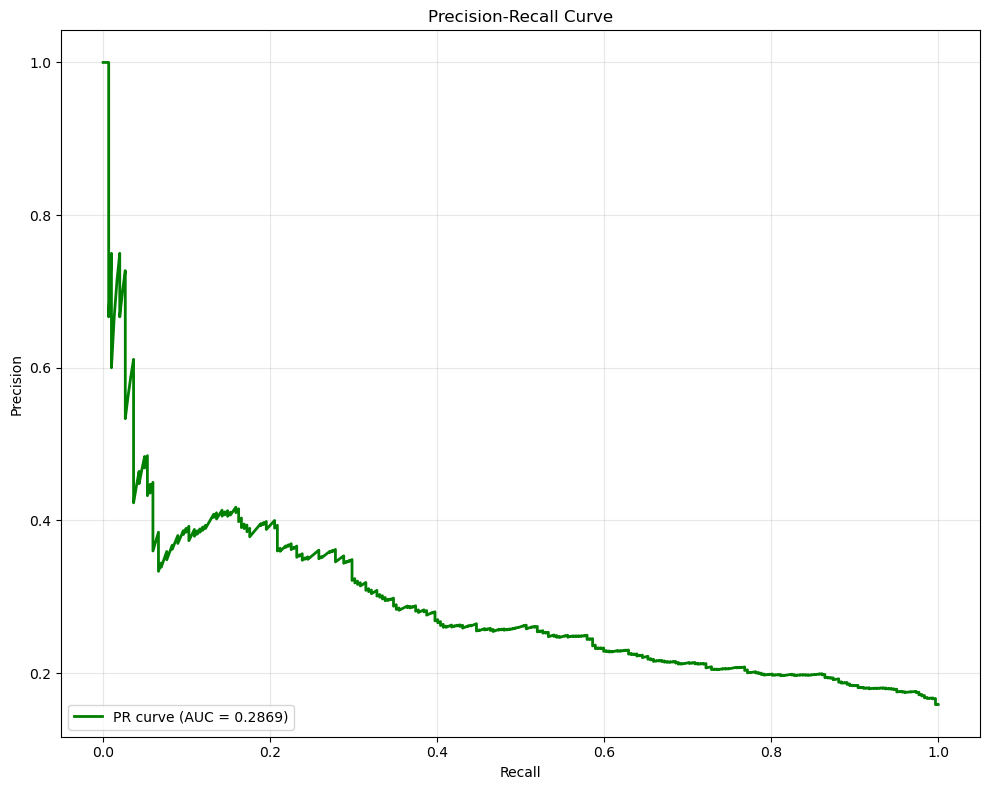

In [33]:
# Calculate and display precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/precision_recall_curve_final.png')
plt.show()


In [34]:
### the model is too conservative, we can try to increase the recall by lowering the threshold
# Set a lower threshold to increase recall

optimal_threshold = 0.62
print(f"using lowered threshold: {optimal_threshold:.2f}")

using lowered threshold: 0.62


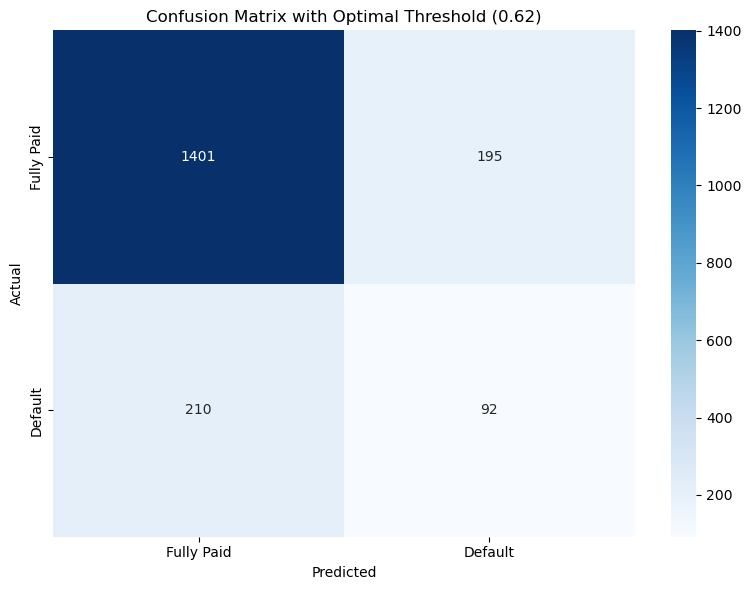

In [35]:
# Apply the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Generate confusion matrix with optimal threshold
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix with Optimal Threshold ({optimal_threshold:.2f})')
plt.tight_layout()
plt.savefig('./figures/model_metrics/confusion_matrix_optimal_1.png')
plt.show()

In [36]:
# Calculate and display classification report
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))



Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1596
           1       0.32      0.30      0.31       302

    accuracy                           0.79      1898
   macro avg       0.60      0.59      0.59      1898
weighted avg       0.78      0.79      0.78      1898



In [37]:
# Business impact analysis
total_loans = len(y_test)
default_rate = sum(y_test) / total_loans

# Using our example business metrics from earlier
avg_loan_amount = 10000
profit_correct_approval = 1500
loss_from_default = -5000

# Calculate business metrics
total_loan_value = total_loans * avg_loan_amount
approved_loans = tp + fp
rejected_loans = tn + fn
approval_rate = approved_loans / total_loans

In [38]:
# Profit calculation
profit_from_true_positives = tp * profit_correct_approval
loss_from_false_positives = fp * loss_from_default
net_profit = profit_from_true_positives + loss_from_false_positives
profit_per_approved_loan = net_profit / approved_loans if approved_loans > 0 else 0
profit_per_total_loan = net_profit / total_loans


In [39]:

print("\nBusiness Impact Analysis:")
print(f"Total number of loans evaluated: {total_loans}")
print(f"Actual default rate: {default_rate:.2%}")
print(f"Loans approved: {approved_loans} ({approval_rate:.2%})")
print(f"Loans rejected: {rejected_loans} ({1-approval_rate:.2%})")
print(f"Correct approvals (TP): {tp}")
print(f"Incorrect approvals (FP): {fp}")
print(f"Missed opportunities (FN): {fn}")
print(f"Correct rejections (TN): {tn}")
print(f"\nTotal profit: ${net_profit:.2f}")
print(f"Profit per approved loan: ${profit_per_approved_loan:.2f}")
print(f"Profit per loan in portfolio: ${profit_per_total_loan:.2f}")



Business Impact Analysis:
Total number of loans evaluated: 1898
Actual default rate: 15.91%
Loans approved: 287 (15.12%)
Loans rejected: 1611 (84.88%)
Correct approvals (TP): 92
Incorrect approvals (FP): 195
Missed opportunities (FN): 210
Correct rejections (TN): 1401

Total profit: $-837000.00
Profit per approved loan: $-2916.38
Profit per loan in portfolio: $-440.99


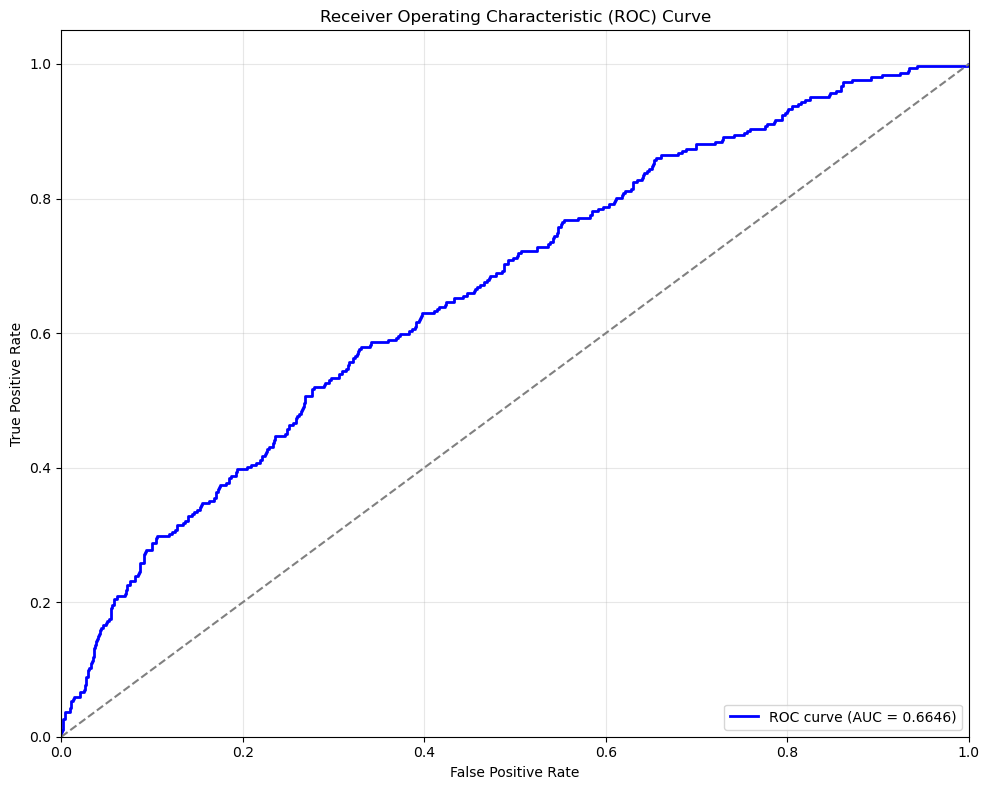

In [40]:
# Calculate and display ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/model_metrics/roc_curve_final_1.png')
plt.show()

In [42]:
import joblib


print("\n" + "="*50)
print("Saving final model and threshold...")
print("="*50)

# Create a dictionary containing the model and optimal threshold
final_model_package = {
    'model': tuned_model,
    'optimal_threshold': optimal_threshold,
    'feature_names': feature_names,
    'feature_importance': feature_importance
}

# Save the final model package
joblib.dump(final_model_package, 'final_loan_default_model.pkl')
print("Final model package saved as 'final_loan_default_model.pkl'")



Saving final model and threshold...
Final model package saved as 'final_loan_default_model.pkl'
